In [65]:
%matplotlib inline
import pandas as pd
import numpy as np
import math

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import DBSCAN

import seaborn.apionly as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('ggplot')

from plot_functions import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Clustering uncorrelated levels

In this last part, we will cluster the uncorrelated samples, trying to find interesting patterns.<br/>
To do that, we will use the Pearson's correlation coefficient, selecting uncorrelated samples for several thresholds.<br/>
Our clustering methods will be the K-Means and Ward.<br/>
Finally, we will analyse the resulting clusters.

### Loading data

In [2]:
# Unstandardized data
prot_data_without_norm = pd.read_csv('data/data_prot.csv', index_col=0)
mRNA_data_without_norm = pd.read_csv('data/data_mRNA.csv', index_col=0)
data_without_norm = pd.read_csv('data/data.csv', index_col=0)

# Standardized data
prot_data = pd.read_csv('data/data_prot_norm.csv', index_col=0)
mRNA_data = pd.read_csv('data/data_mRNA_norm.csv', index_col=0)
data = pd.read_csv('data/data_norm.csv', index_col=0)

## I - Uncorrelated entries extraction

We can compute the correlation using the Pearson's coefficient :

In [3]:
def compute_corr(k):
    return prot_data.iloc[k].corr(mRNA_data.iloc[k], method='pearson')

We compute the coefficient for each mRNA/protein pair :

In [4]:
correl = np.zeros((data.shape[0],))
for k in range(data.shape[0]):
    correl[k] = compute_corr(k)

corr_ = pd.Series(correl, index=data.index)

We extract uncorrelated entries for several threseholds :

In [70]:
thr = [0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02, 0.01]
uncorrelated_data_index, uncorrelated_data, uncorrelated_prot, uncorrelated_mRNA = {}, {}, {}, {}

for t in thr:
    index = uncorrelated_data_index[t] = corr_[np.abs(corr_) <t].index.values
    uncorrelated_data[t] = data.loc[index]
    uncorrelated_mRNA[t] = mRNA_data.loc[index]
    uncorrelated_prot[t] = prot_data.loc[index]
    
    print('{} samples for |corr| < {} \t Max number of clusters = {}'.format(len(index), t, int(math.log2(len(index)))))

1002 samples for |corr| < 0.3 	 Max number of clusters = 9
822 samples for |corr| < 0.25 	 Max number of clusters = 9
636 samples for |corr| < 0.2 	 Max number of clusters = 9
459 samples for |corr| < 0.15 	 Max number of clusters = 8
301 samples for |corr| < 0.1 	 Max number of clusters = 8
151 samples for |corr| < 0.05 	 Max number of clusters = 7
64 samples for |corr| < 0.02 	 Max number of clusters = 6
29 samples for |corr| < 0.01 	 Max number of clusters = 4


Notice that our number of entries is considerably reduced, and that we shouldn't choose a number of clusters k when we have less than 2^k entries.

## II - K-means

In [71]:
def kmeans(df, k):
    kmeans_model = KMeans(n_clusters=k)
    model = kmeans_model.fit(df)
    score = silhouette_score(df, model.labels_)
    return model, score

We learn the model for several thresholds and k :

In [74]:
thr = [0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02, 0.01]
n_clust = range(2,10) 

data_model, data_score = {}, {}

for t in thr:
    data_model[t], data_score[t] = {}, {}
    
    for k in n_clust: 
        data_model[t][k], data_score[t][k] = kmeans(uncorrelated_data[t], k)

Let's observe the Silhouette score's evolution :

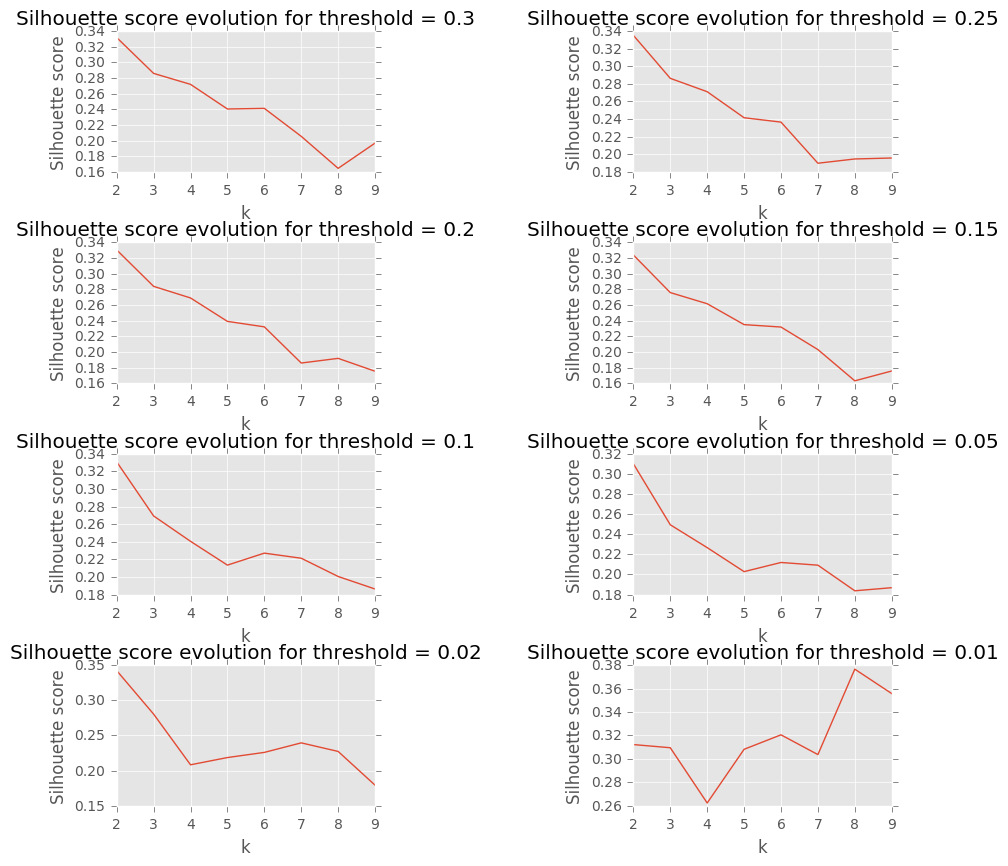

In [76]:
f, axarr = plt.subplots(4,2, figsize=(10,10))

for it, t in enumerate(thr) :
    scores = pd.Series(data_score[t], name='Score')
    scores.index.name = 'k'

    x = it // 2
    y = it % 2
    
    axarr[x,y].plot(scores)
    axarr[x,y].set_xlabel('k')
    axarr[x,y].set_ylabel("Silhouette score")
    axarr[x,y].set_title("Silhouette score evolution for threshold = "+str(t))

f.subplots_adjust(hspace=0.5, wspace=1)
plt.show()

The silhouette score tends to decrease when we increase the number of clusters. (It is not the case for thr = 0.01, but we shouldn't cluster these data for k > 4).

Let's plot the results :

k = 2


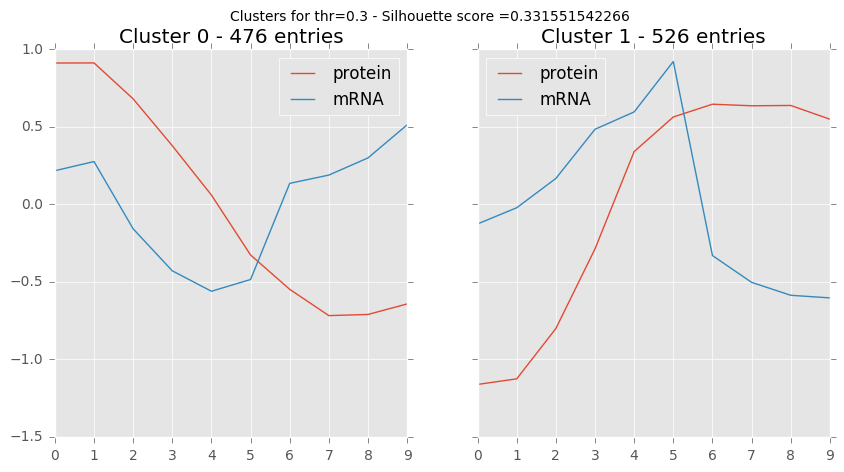

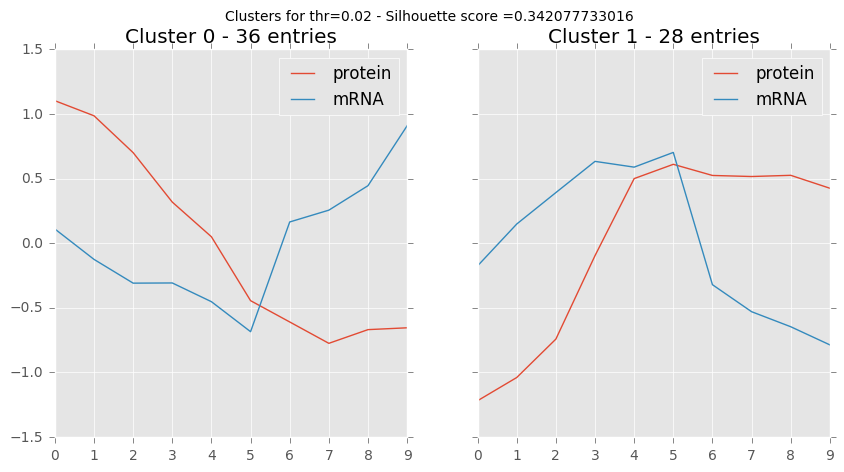

k = 3


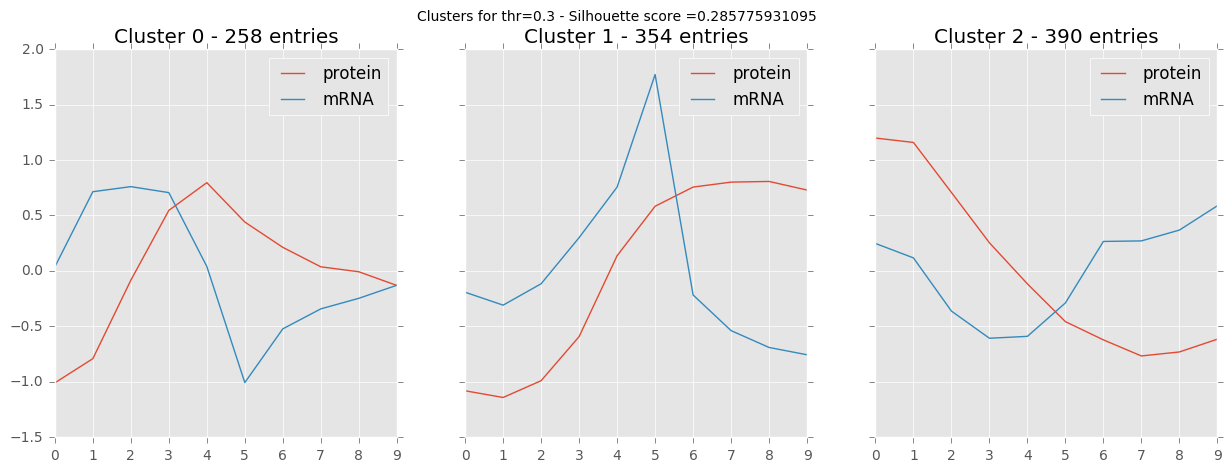

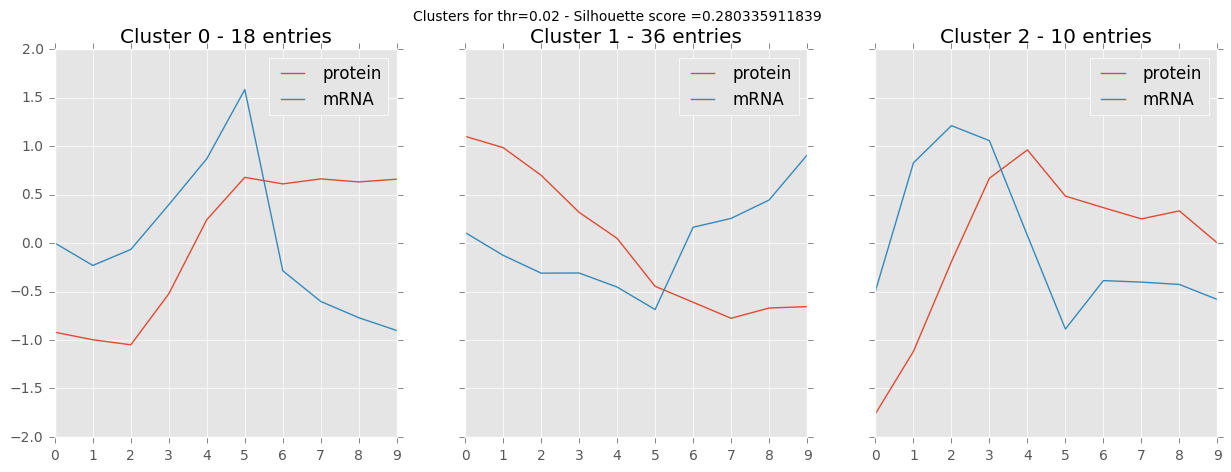

k = 4


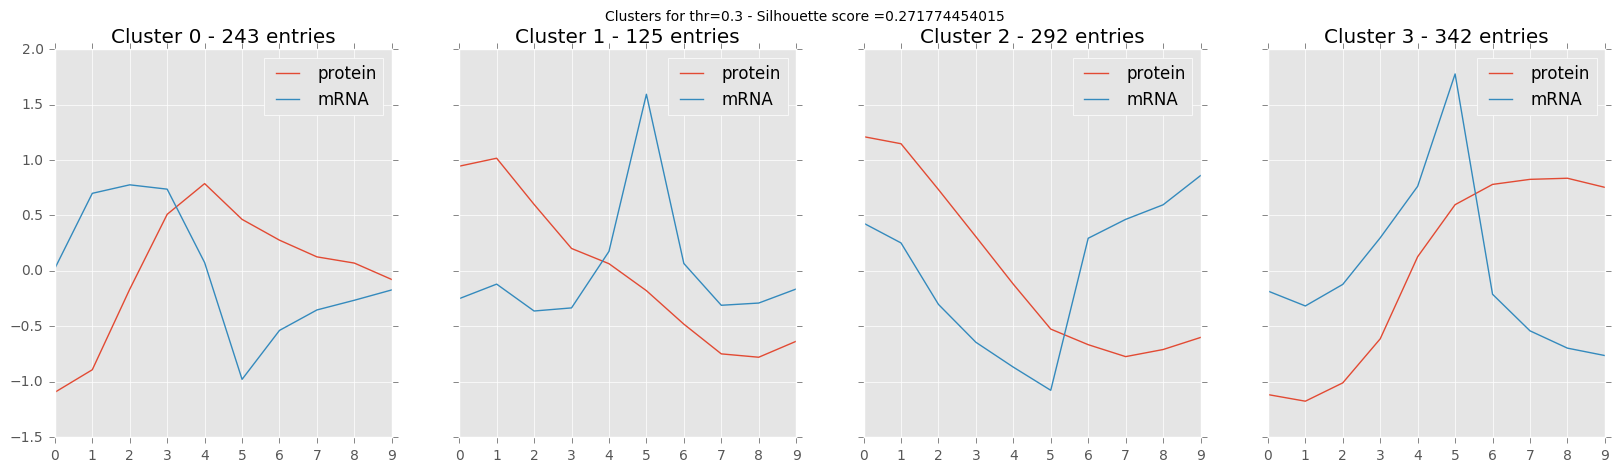

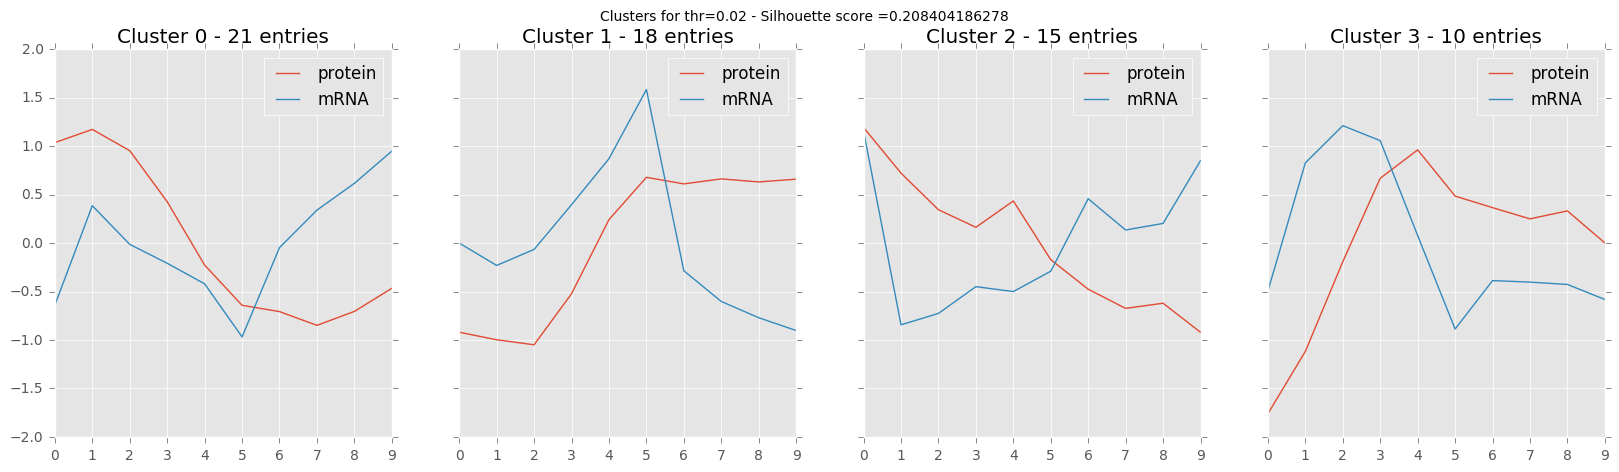

In [97]:
for n_clust in [2, 3, 4]:
    
    print("k = {}".format(n_clust))
    
    for t in [0.3, 0.02] :
        
        f, axarr = plt.subplots(1,n_clust, figsize=(5*n_clust,5), sharey=True)
        f.suptitle('Clusters for thr='+str(t)+' - Silhouette score ='+str(data_score[t][n_clust]))

        for k in range(n_clust):
            axarr[k].plot(data_model[t][n_clust].cluster_centers_[k,0:10], label = "protein")
            axarr[k].plot(data_model[t][n_clust].cluster_centers_[k,10:20], label = "mRNA")
            axarr[k].set_title('Cluster '+str(k)+' - '+str(np.sum(data_model[t][n_clust].labels_ == k))+' entries')
            axarr[k].legend(loc='best')
        plt.show()

#### Observations

We find the **same patterns** for each threshold (only 0.3 and 0.02 are showed) :
- k = 2 : 
    - c0 (0.3) corresponds to c0 (0.02)
    - c1 (0.3) corresponds to c1 (0.02)
- k = 3 :
    - c0 (0.3) corresponds to c2 (0.02)
    - c1 (0.3) corresponds to c0 (0.02)
    - c2 (0.3) corresponds to c1 (0.02)
- k = 4 :
    - c0 (0.3) corresponds to c3 (0.02)
    - c1 (0.3) corresponds to c2 (0.02) 
    - c2 (0.3) corresponds to c0 (0.02) 
    - c3 (0.3) corresponds to c1 (0.02) 

But these patterns were also observed when we clustered the whole cluster :
- For k = 2, the clusters are the same
- For k = 3, only c0 (0.3) is new
- For k = 4, only c1 (0.3) is new

Moreover, when k increase, we always keep the clusters for k-1 :
- For k = 3, c0 (0.3) is new.
- For k = 4, c1 (0.3) is new.

#### Context

Studies show that correlation between mRNA and proteins levels are often weak.<br/>
Indeed, these levels depends a lot on the cell's environment (and thus, on the cell's needs).<br/>
These environment and needs are the source of **regulatory processes** occurring after mRNA is made :

- **Post-transcriptional regulation** *(After DNA -> NRA)*<br/>
    Ex :<br/>
    - The mRNA can be made silent *(=> mRNA present but protein is not produced)*
    - The mRNA can be degraged *(=> mRNA reduction but previously produced proteins may be still living)*

- **Translational regulation** *(During ARN -> NRA)*<br/>
    Ex :<br/>
    - The ribosomes can be inhibated or degraded *(=> mRNA present but protein is not produced)*

- **Post-translational regulation** *(After NRA -> protein)*
    Ex :<br/>
    - The protein can be degraded *(=> mRNA present but protein is not produced)*
    - The protein's lifetime can be altered *(=> Protein may live less)*

These mecanisms contribute to control steady-state protein abundances.

#### Analysis

For our clusters analysis, we will use the cluster's numbers for a threshold of 0.3.<br/>
As the clusters for a number of clusters k include the cluster for a number of cluster k-1, we will analyse the clusters for k = 4.
- c0 :<br/>
The levels are correlated until t5 (with our correlation between t(mRNA) and t+1(proteins)) : the high mRNA levels result in an increase in proteins levels, and the decrease in mRNA levels causes a decrease in proteins levels.<br/>
However, the increase in mRNA levels from t5 should have implied an increase in proteins levels, and it is not the case. <br/>
One possible explanation resides in regulatory processes (The mRNA can be made silencious, or proteins or ribosomes can be degraded)
- c1 :<br/>
mRNA level is increasing until t5 where it reaches a peak, and the decrease, whereas the protein level is continuously decreasing. Again, it can be explain the regulatory processes : the mRNA is produced for some reasons while the cell doesn't need the protein. Then, the protein isn't produced.
- c2 :<br/>
The proteins levels decrease continuously whereas the mRNA levels decrease until t5 and then increase.<br/>
This increase should have cause an increase in the proteins levels.<br/>
Again, one possible explanation resides in regulatory processes (The mRNA can be made silencious, or proteins or ribosomes can be degraded)
- c3 : <br/>
mRNA level increases until t5 (and reaches a peak) and then decrease whereas proteins level increases until t6 and then stabilizes.<br/>
One explanation could be that : the cell needed the protein, and then produces mRNA, involving an increase in the protein's level. When the cell has enough protein, it stops producing mRNA, but the previously produced proteins are still living.

Finally, we always observe a major variation at **t5**, and all uncorrelation patterns can be seen as illustrations of regulatory processes.

## II - Hierarchical clustering

First, we define a function enabling to fit the model :

In [83]:
def hierarchical_clustering(df, k):
    ward_model = AgglomerativeClustering(n_clusters=k, linkage='ward')
    model = ward_model.fit(df)
    score = silhouette_score(df, model.labels_)
    return model, score

Then we learn the model for several numbers of clusters (k) :

In [86]:
thr = [0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02, 0.01]
n_clust = range(2,10) 
ward_model, ward_score = {}, {}

for t in thr:
    ward_model[t], ward_score[t] = {}, {}
    
    for k in n_clust: 
        ward_model[t][k], ward_score[t][k] = hierarchical_clustering(uncorrelated_data[t], k)

Let's observe the Silhouette score's evolution :

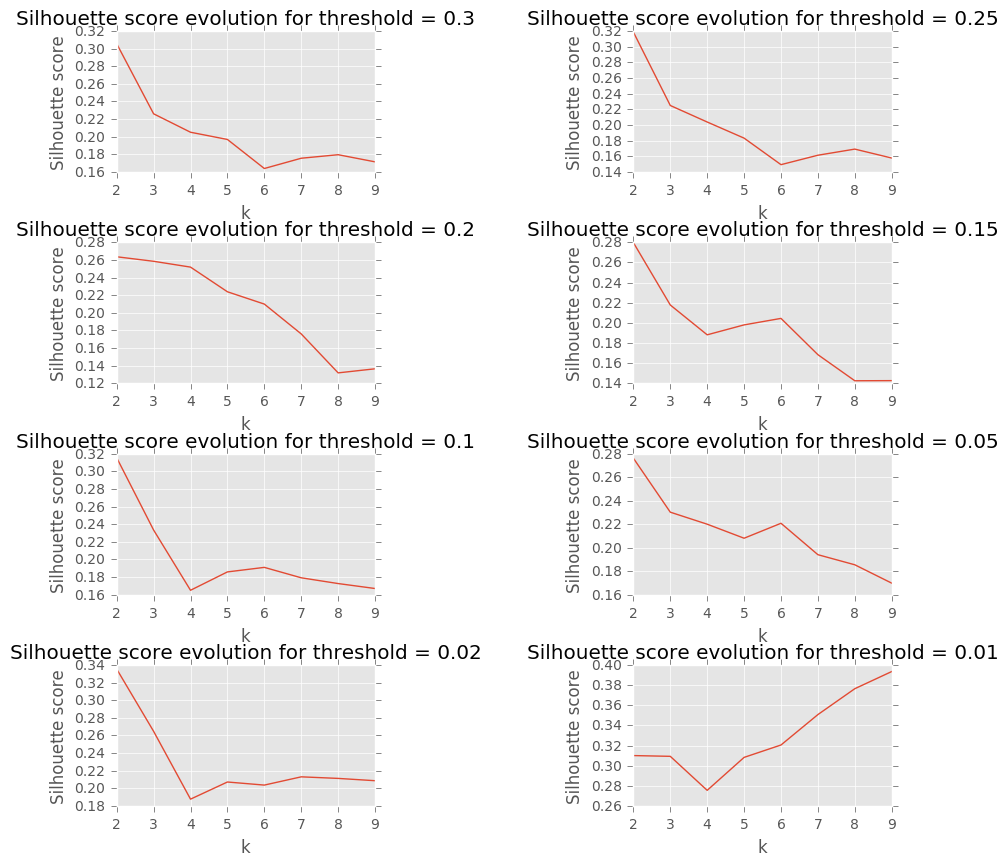

In [87]:
f, axarr = plt.subplots(4,2, figsize=(10,10))

for it, t in enumerate(thr) :
    scores = pd.Series(ward_score[t], name='Score')
    scores.index.name = 'k'

    x = it // 2
    y = it % 2
    
    axarr[x,y].plot(scores)
    axarr[x,y].set_xlabel('k')
    axarr[x,y].set_ylabel("Silhouette score")
    axarr[x,y].set_title("Silhouette score evolution for threshold = "+str(t))

f.subplots_adjust(hspace=0.5, wspace=1)
plt.show()

As usual, the silhouette score tends to decrease when we increase the number of clusters. (It is not the case for thr = 0.01, but we shouldn't cluster these data for k > 4).<br/>
However, we can find some extrema :
- For thresholds of 0.3 and 0.25, we have a minimum for k = 6
- For a threshold of 0.2, we have a minimum for k = 8
- For thresholds of 0.15, 0.1 and 0.05, we have a local maximimum for k = 6

Let's plot the results :

k = 2


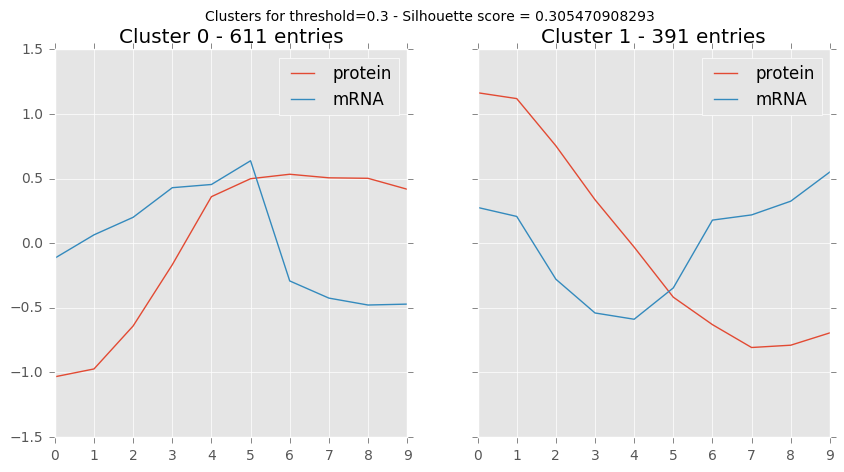

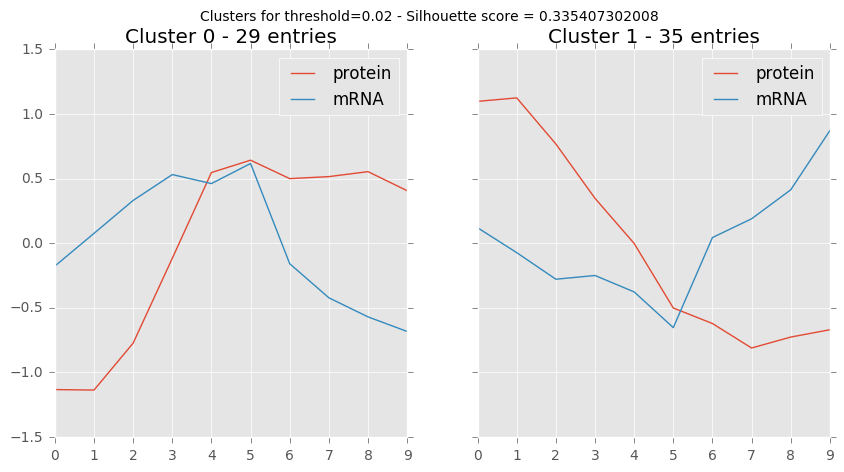

k = 3


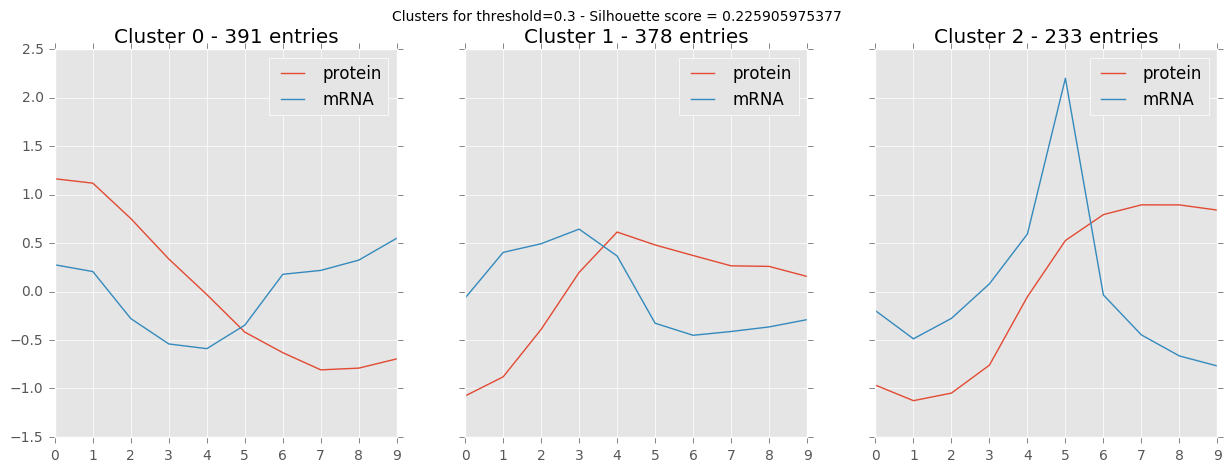

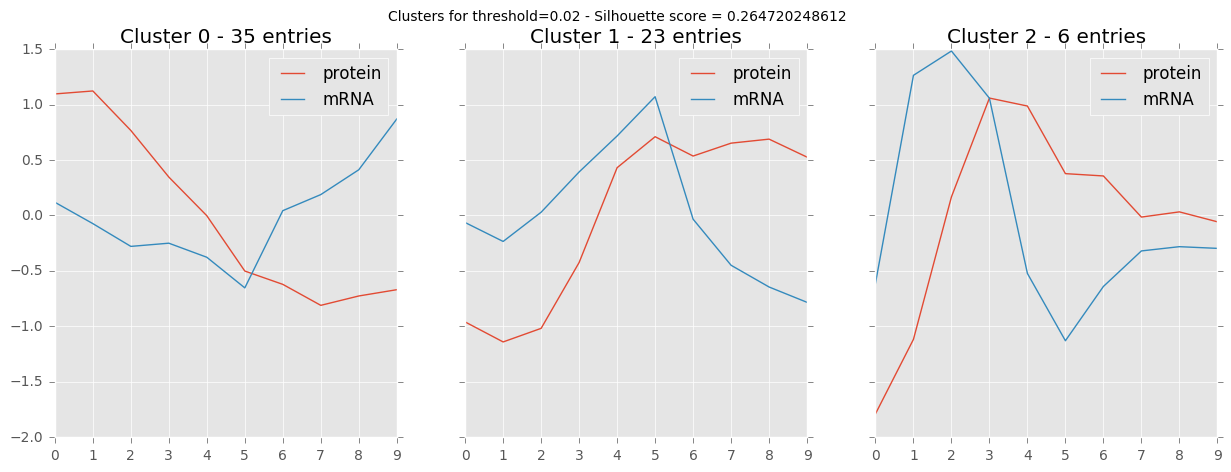

k = 4


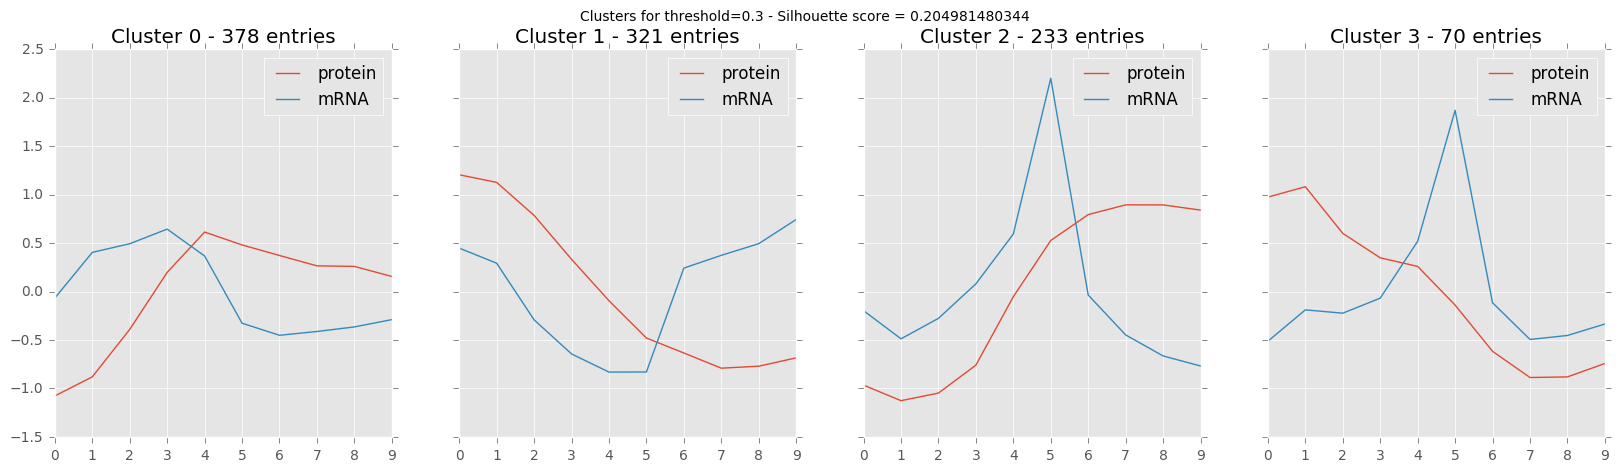

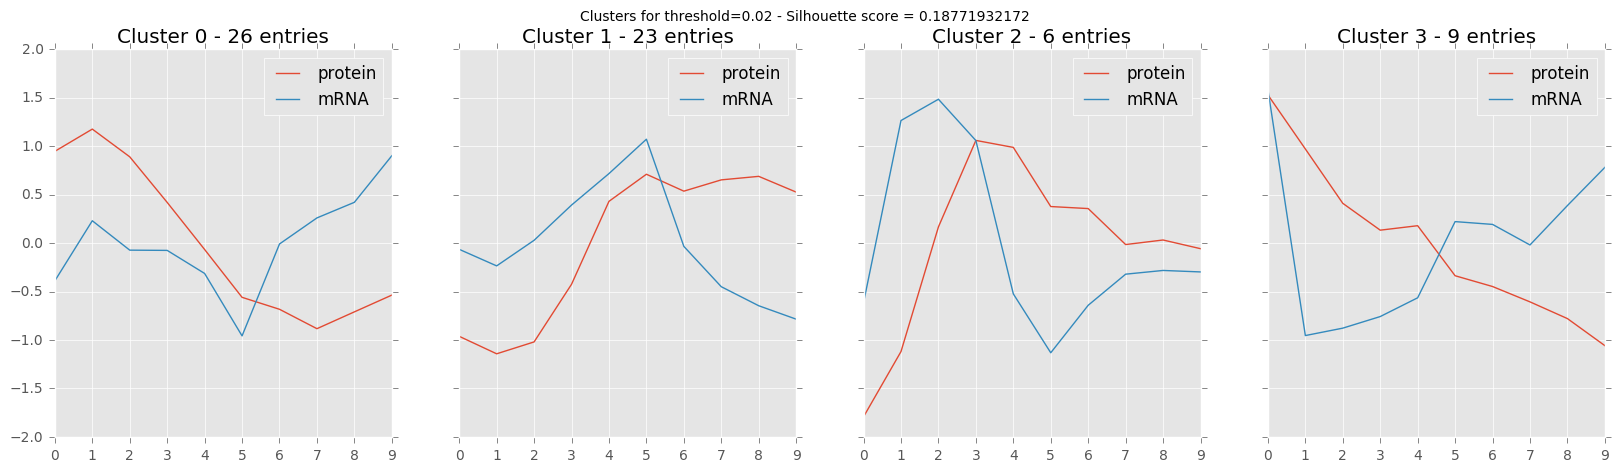

In [98]:
for n_clust in [2, 3, 4]:
    print("k = {}".format(n_clust))
    for t in [0.3, 0.02] :
        
        f, axarr = plt.subplots(1,n_clust, figsize=(5*n_clust,5), sharey=True)
        f.suptitle('Clusters for threshold='+str(t)+' - Silhouette score = '+str(ward_score[t][n_clust]))

        for k in range(n_clust):
            axarr[k].plot(pd.DataFrame(uncorrelated_prot[t].iloc[np.where(ward_model[t][n_clust].labels_==k)].values).mean(), 
                          label = "protein")
            axarr[k].plot(pd.DataFrame(uncorrelated_mRNA[t].iloc[np.where(ward_model[t][n_clust].labels_==k)].values).mean(), 
                                       label = "mRNA")
            axarr[k].set_title('Cluster '+str(k)+' - '+str(np.sum(ward_model[t][n_clust].labels_ == k))+' entries')
            axarr[k].legend(loc='best')
        plt.show()

For each k, we can associate the clusters to those obtained using the K-Means method.